In [2]:
# Jon's notebook

# remember to add non-visual graphics

In [3]:
# Contents (like Daniels)

# with hyperlinks within document?

# Overview

- business / data understanding - what kind of data are you using? and what makes it well-suited for the business problem
- data prep - why did you choose the data prep steps that you did? and what was the result
- modeling - what modeling packages did you use, which models within the packages, and what tuning steps did you take?
- evaluation - How well did your model perform? Relevant metrics. Validation approach

# Business and Data Understanding

what kind of data are you using? and what makes it well-suited for the business problem

# Data Preparation 

feature engineering, using pipelines or using unsupervised techniques

## Imports

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor 

import pickle

## Loading in data files

### Links from MovieLens to IMDB and TMDB

- for IMDB: https://www.imdb.com/tt then movie id
- for TMDB: https://www.themoviedb.org/movie/ then movie id

In [39]:
links = pd.read_csv('data/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [7]:
links.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

### Movie IDs with Title and Genres

only movies with at least one rating or tag are included, per MovieLens

Movie IDs are consistent across all four data files, and correspond with the __[MovieLens.org/movies/](https://movielens.org/movies/)__ URL

Genres are a pipe-separated list selected from the following:
- Action
- Adventure
- Animation
- Children's
- Comedy
- Crime
- Documentary
- Drama
- Fantasy
- Film-Noir
- Horror
- Musical
- Mystery
- Romance
- Sci-Fi
- Thriller
- War
- Western
- (no genres listed)

In [8]:
movies = pd.read_csv('data/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [10]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

### User Ratings (min. 20 per userid)

user id is the same with tags.csv below too

Users are selected for inclusion at random per MovieLens

Ratings are made on a 5 star scale, with half-star increments (0.5 - 5.0)

In [11]:
ratings = pd.read_csv('data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [13]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

### Tags provided by user

Tags are "user-generated metadata about movies...typically a single word or short phrase"

Timestamp represents seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970

In [14]:
tags = pd.read_csv('data/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [15]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [16]:
tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

## Combined dataframe with movies and ratings

In [253]:
df = pd.merge(movies, ratings, on='movieId')
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [127]:
len(df)

100836

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [20]:
df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [21]:
df.describe()

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


# Modeling

- Rationale, results, limitations & recommendations
- Multiple different packages & model explainability tools

In [21]:
# start with dummy / simple model
# then clear explanation why you went from one model to the next
# cross val scores
# why is this going to help your model?

# limitations: cold start.  At least talk about.  Maybe hybrid model
# with content-based filtering to start?

## Surprise Data and train/test split

In [22]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [23]:
# train/test split at 80/20

trainset, testset = train_test_split(data, test_size=0.2, random_state=24)


In [24]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')
print('Number of ratings: ', trainset.n_ratings, '\n')

Number of users:  610 

Number of items:  9010 

Number of ratings:  80668 



In [25]:
# confirming 80% trainset

(trainset.n_ratings) / len(df)

0.7999920663255187

## Baseline Simple Model - Random Rating

The NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal.

In [26]:
# from Daniel

# Instantiate and fit model
baseline = NormalPredictor()
baseline.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline.test(testset)

# Save RMSE score to variable
baseline_normal = accuracy.rmse(predictions)

RMSE: 1.4281


In [27]:
cross_validate(baseline, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4302  1.4264  1.4317  1.4294  0.0022  
Fit time          0.06    0.06    0.05    0.06    0.00    
Test time         0.20    0.13    0.12    0.15    0.03    


{'test_rmse': array([1.43018394, 1.42640399, 1.43170528]),
 'fit_time': (0.06419873237609863, 0.06484317779541016, 0.0548248291015625),
 'test_time': (0.19518351554870605, 0.13066387176513672, 0.12341928482055664)}

## Baseline Simple Model - Baseline Estimate
Using Alternating Least Squares

In [28]:
# from Daniel

# Instantiate and fit model
baseline2 = BaselineOnly()
baseline2.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline2.test(testset)

# Save RMSE score to variable
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.8683


In [29]:
cross_validate(baseline2, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8709  0.8811  0.8798  0.8773  0.0045  
Fit time          0.04    0.05    0.04    0.04    0.00    
Test time         0.12    0.09    0.09    0.10    0.01    


{'test_rmse': array([0.87093821, 0.88108248, 0.87984931]),
 'fit_time': (0.0382227897644043, 0.04540848731994629, 0.04196786880493164),
 'test_time': (0.1170053482055664, 0.09234762191772461, 0.08936476707458496)}

## SVD and Cross-validating a Simple Model

Our first matrix factorization-based algorithm and model

In [30]:
# Funk's SVD, no hyperparameters

svd_basic = SVD(random_state=24)
cross_validate(svd_basic, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8864  0.8817  0.8742  0.8808  0.0050  
Fit time          3.61    3.75    3.73    3.70    0.06    
Test time         0.29    0.30    0.30    0.30    0.01    


{'test_rmse': array([0.88635185, 0.88172091, 0.87422517]),
 'fit_time': (3.6125781536102295, 3.749753475189209, 3.733705997467041),
 'test_time': (0.28885960578918457, 0.29909682273864746, 0.303086519241333)}

In [31]:
# from Daniel

# Fit to trainset and predict on the testset for evaluation
svd_basic.fit(trainset)
predictions = svd_basic.test(testset)
svd_simple = accuracy.rmse(predictions)

RMSE: 0.8698


In [ ]:
# svd_simple = SVD(verbose=True, n_epochs=10)
# cross_validate(svd_simple, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

In [ ]:
# Canvas - 

# trainset, testset = train_test_split(jokes, test_size=0.2)

In [ ]:
# print(len(testset))

## GridSearchCV

In [67]:
# from Canvas


# dictionary of hyperparameters
svd_param_grid = {'n_factors':[20, 50, 100],
                  'n_epochs': [5, 10], 
                  'lr_all': [0.002, 0.005, 0.05],
                  'reg_all': [0.01, 0.1, 0.5],
                 'biased': [True, False]}
# instantiate
# svd_gs_model = GridSearchCV(SVD,param_grid=svd_param_grid,measures=['rmse'],n_jobs = -2,joblib_verbose=5)

# model is fit and best_params scored by RMSE
svd_gs_model.fit(data)
svd_gs_model.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-2)]: Done 266 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-2)]: Done 428 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 540 out of 540 | elapsed:  2.5min finished


{'n_factors': 100,
 'n_epochs': 10,
 'lr_all': 0.05,
 'reg_all': 0.1,
 'biased': True}

In [35]:
svd = SVD(n_factors=100, n_epochs=10, lr_all=0.05, reg_all=0.1, biased=True, random_state=24)
svd.fit(trainset)
predictions = svd.test(testset)
svd_gs1 = accuracy.rmse(predictions)

RMSE: 0.8543


In [33]:
cross_validate(svd, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8657  0.8692  0.8619  0.8656  0.0030  
Fit time          1.77    1.75    1.80    1.78    0.02    
Test time         0.29    0.30    0.29    0.29    0.00    


{'test_rmse': array([0.86566399, 0.86918133, 0.86187192]),
 'fit_time': (1.772707462310791, 1.750173807144165, 1.8028326034545898),
 'test_time': (0.2925539016723633, 0.29720425605773926, 0.29221606254577637)}

In [ ]:
# Can put in multiple GridSearches here, with rationale for tweaks

In [199]:
# Sam's best SVD model so far

svd_sam = SVD(n_factors=30, n_epochs=30, lr_all=0.01, reg_all=0.1, random_state=10)
svd_sam.fit(trainset)
predictions = svd_sam.test(testset)
svd_sam_1 = accuracy.rmse(predictions)

RMSE: 0.8542


In [200]:
cross_validate(svd_sam, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8636  0.8676  0.8681  0.8664  0.0020  
Fit time          2.06    2.02    2.03    2.04    0.02    
Test time         0.20    0.17    0.16    0.17    0.02    


{'test_rmse': array([0.86357914, 0.86757826, 0.86814115]),
 'fit_time': (2.0637502670288086, 2.0239906311035156, 2.028501272201538),
 'test_time': (0.19817614555358887, 0.1673288345336914, 0.1584935188293457)}

## Non-negative Matrix Factorization

A collaborative filtering algorithm based on Non-negative Matrix Factorization.

This algorithm is very similar to SVD. The user and item factors are kept positive.

The optimization procedure is a (regularized) stochastic gradient descent with a specific choice of step size that ensures non-negativity of factors, provided that their initial values are also positive.

In [70]:
# from Daniel.  Says keep n_factors low to minimize bias

# New hyperparameter dictionary for nmf model
nmf_param_grid = {'biased':[True, False],
                  'n_factors':[1, 5, 10],
                  'n_epochs': [25, 50]}
# nmf_gs_model = GridSearchCV(NMF, param_grid=nmf_param_grid, measures=['rmse'], cv=3, joblib_verbose=10, n_jobs=-2, return_train_measures=True)

# Fit and return the best hyperparameters
nmf_gs_model.fit(data)
nmf_gs_model.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-2)]: Done  19 out of  36 | elapsed:   10.8s remaining:    9.7s
[Parallel(n_jobs=-2)]: Done  23 out of  36 | elapsed:   11.7s remaining:    6.6s
[Parallel(n_jobs=-2)]: Done  27 out of  36 | elapsed:   12.3s remaining:    4.0s
[Parallel(n_jobs=-2)]: Done  31 out of  36 | elapsed:   15.7s remaining:    2.4s
[Parallel(n_jobs=-2)]: Done  36 out of  36 | elapsed:   18.3s finished


{'biased': True, 'n_factors': 1, 'n_epochs': 50}

In [34]:
# from Daniel

# Instantiate - fit on trainset - score the model on testset
nmf_model = NMF(n_factors=1, n_epochs=50, random_state=24, biased=True)
nmf_model.fit(trainset)
predictions = nmf_model.test(testset)
nmf_gs = accuracy.rmse(predictions)

RMSE: 0.8667


In [36]:
cross_validate(nmf_model, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8813  0.8720  0.8714  0.8749  0.0045  
Fit time          2.39    2.37    2.34    2.37    0.02    
Test time         0.28    0.32    0.34    0.31    0.02    


{'test_rmse': array([0.88132983, 0.87197823, 0.87143546]),
 'fit_time': (2.3947153091430664, 2.369126319885254, 2.339139461517334),
 'test_time': (0.27863144874572754, 0.31635427474975586, 0.3367912769317627)}

In [ ]:
# worse than basic SVD and subsequent searches

## SVD++ Model

The SVD++ algorithm, an extension of SVD taking into account implicit ratings

In [37]:
# instantiating default SVDpp

svdpp_default_model = SVDpp(random_state=24)

# Fit and return RMSE
svdpp_default_model.fit(trainset)
predictions = svdpp_default_model.test(testset)
svdpp_default = accuracy.rmse(predictions)

RMSE: 0.8574


In [38]:
cross_validate(svdpp_default_model, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8655  0.8703  0.8762  0.8707  0.0044  
Fit time          439.02  436.58  432.72  436.11  2.59    
Test time         12.62   12.70   12.61   12.64   0.04    


{'test_rmse': array([0.8655341 , 0.87034932, 0.8762258 ]),
 'fit_time': (439.0216438770294, 436.57994651794434, 432.7243502140045),
 'test_time': (12.624337196350098, 12.703818082809448, 12.60663628578186)}

In [79]:
# from Daniel

# New dictionary for SVD++
svdpp_param_grid = {'n_factors':[5, 10],
                    'n_epochs':[25, 50],
                    'reg_all':[0.02, 0.05]}
# svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=10, n_jobs=-2, return_train_measures=True)

# Fit and return the best_params based on cross validation.  
svdpp_gs_model.fit(data)
svdpp_gs_model.best_params['rmse']

# Grid search took 1 hr

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-2)]: Done   6 out of  24 | elapsed: 11.8min remaining: 35.3min
[Parallel(n_jobs=-2)]: Done   9 out of  24 | elapsed: 24.9min remaining: 41.4min
[Parallel(n_jobs=-2)]: Done  12 out of  24 | elapsed: 32.4min remaining: 32.4min
[Parallel(n_jobs=-2)]: Done  15 out of  24 | elapsed: 32.7min remaining: 19.6min
[Parallel(n_jobs=-2)]: Done  18 out of  24 | elapsed: 43.6min remaining: 14.5min
[Parallel(n_jobs=-2)]: Done  21 out of  24 | elapsed: 56.0min remaining:  8.0min
[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed: 57.8min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed: 57.8min finished


{'n_factors': 5, 'n_epochs': 25, 'reg_all': 0.05}

In [40]:
# Instantiate - fit on trainset - score the model on testset
svdpp_model = SVDpp(n_factors=5, n_epochs=25, random_state=24, reg_all=0.05)
svdpp_model.fit(trainset)
predictions = svdpp_model.test(testset)
svdpp_gs = accuracy.rmse(predictions)

RMSE: 0.8545


In [41]:
cross_validate(svdpp_model, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8671  0.8655  0.8616  0.8647  0.0023  
Fit time          226.95  229.40  227.68  228.01  1.03    
Test time         9.33    8.53    8.92    8.93    0.33    


{'test_rmse': array([0.86705714, 0.86551326, 0.86164987]),
 'fit_time': (226.95001912117004, 229.40389609336853, 227.67597913742065),
 'test_time': (9.333841562271118, 8.53317141532898, 8.923373222351074)}

# Model Evaluation

## Initial Visuals

In [215]:
X = ['Random', 'SVD Simple', 'Baseline Only', 'NMF GS', 'SVDpp default', 'SVDpp GS', 'SVD GS1', "Sam's SVD"]
y = [baseline_normal, baseline_only, svd_simple, svd_gs1, nmf_gs, svdpp_default, svdpp_gs, svd_sam_1]

In [216]:
X, y

(['Random',
  'SVD Simple',
  'Baseline Only',
  'NMF GS',
  'SVDpp default',
  'SVDpp GS',
  'SVD GS1',
  "Sam's SVD"],
 [1.428058412387589,
  0.8682632466736847,
  0.8698355278044364,
  0.8543242157542599,
  0.8666933019945887,
  0.8574257005996032,
  0.8545336031383114,
  0.8541938111535279])

In [217]:
y_sort = sorted(y, reverse=True)

In [218]:
y_sort

[1.428058412387589,
 0.8698355278044364,
 0.8682632466736847,
 0.8666933019945887,
 0.8574257005996032,
 0.8545336031383114,
 0.8543242157542599,
 0.8541938111535279]

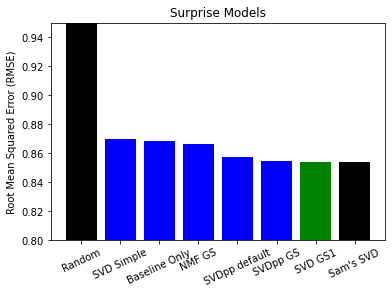

In [220]:
fig, ax = plt.subplots()
plt.bar(X, y_sort, color=['black', 'blue', 'blue', 'blue', 'blue', 'blue', 'green'])
plt.xticks(rotation=25)
plt.ylim(0.8, 0.95)
plt.grid(False)
ax.set_title("Surprise Models")
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.savefig('images/suprise_models_bar.png', dpi=300, bbox_inches='tight');

## Recommendation Function

In [ ]:
# towards Data Science blog

final_model_train = data.build_full_trainset()
svdpp_gs_model.fit(final_model_train)

### Removing already reviewed movies

In [129]:
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [130]:
df.shape

(100836, 6)

In [131]:
df_drop = df.drop_duplicates('movieId')
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9724 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   movieId    9724 non-null   int64  
 1   title      9724 non-null   object 
 2   genres     9724 non-null   object 
 3   userId     9724 non-null   int64  
 4   rating     9724 non-null   float64
 5   timestamp  9724 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 531.8+ KB


In [132]:
df_reset = df_drop.set_index('movieId')
df_reset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9724 entries, 1 to 193609
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      9724 non-null   object 
 1   genres     9724 non-null   object 
 2   userId     9724 non-null   int64  
 3   rating     9724 non-null   float64
 4   timestamp  9724 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 455.8+ KB


In [135]:
df_reset.shape

(9724, 5)

In [133]:
df_user = df.set_index('userId')
df_user.drop(columns=['title', 'genres', 'rating', 'timestamp'], inplace=True)
df_user.head()

,movieId
userId,
1,1
5,1
7,1
15,1
17,1


In [134]:
df_user.shape

(100836, 1)

In [103]:
df_user.to_csv('data/df_user.csv')

In [136]:
user = int(input('UserId: '))
n_recs = int(input('How many recommendations? '))

UserId: 5
How many recommendations? 3


In [137]:
have_reviewed = list(df_user.loc[user, 'movieId'])

In [138]:
not_reviewed = df_reset.copy()
not_reviewed.drop(have_reviewed, inplace=True)
not_reviewed.reset_index(inplace=True)
not_reviewed.head()

,movieId,title,genres,userId,rating,timestamp
0,2,Jumanji (1995),Adventure|Children|Fantasy,6,4.0,845553522
1,3,Grumpier Old Men (1995),Comedy|Romance,1,4.0,964981247
2,4,Waiting to Exhale (1995),Comedy|Drama|Romance,6,3.0,845554349
3,5,Father of the Bride Part II (1995),Comedy,6,5.0,845553938
4,6,Heat (1995),Action|Crime|Thriller,1,4.0,964982224


In [139]:
not_reviewed.shape

(9680, 6)

In [140]:
not_reviewed['predicted_rating'] = not_reviewed['movieId'].apply(lambda x: svdpp_model.predict(user, x).est)
not_reviewed.sort_values(by='predicted_rating', ascending=False, inplace=True)
not_reviewed.head()

,movieId,title,genres,userId,rating,timestamp,predicted_rating
861,1204,Lawrence of Arabia (1962),Adventure|Drama|War,29,4.5,1308084015,4.382862
558,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,7,4.0,1106636810,4.344967
902,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller,23,3.0,1107162687,4.292481
796,1104,"Streetcar Named Desire, A (1951)",Drama,32,5.0,856737082,4.271327
915,1261,Evil Dead II (Dead by Dawn) (1987),Action|Comedy|Fantasy|Horror,16,4.0,1377476629,4.248950


In [ ]:
#  need to drop movies they've already watched.  before or after .apply.  
# recommends doing before

In [141]:
not_reviewed.head(n_recs)

,movieId,title,genres,userId,rating,timestamp,predicted_rating
861,1204,Lawrence of Arabia (1962),Adventure|Drama|War,29,4.5,1308084015,4.382862
558,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,7,4.0,1106636810,4.344967
902,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller,23,3.0,1107162687,4.292481


In [164]:
# How many unique users are there?

df['userId'].nunique()

610

In [165]:
# What's the highest userId?

df['userId'].max()

# so no skipped numbers from 1 to 610, but function below won't work above 610

610

In [185]:
# from Daniel

def user_recommended_movies():
    
    user = int(input('Please enter a User Id (from 1 to 610): '))
    n_recs = 5 #int(input('How many recommendations?  '))
    
    have_reviewed = list(df_user.loc[user, 'movieId'])
    not_reviewed = df_reset.copy()
    not_reviewed.drop(have_reviewed, inplace=True)
    not_reviewed.reset_index(inplace=True)
    not_reviewed['predicted_rating'] = not_reviewed['movieId'].apply(lambda x: svdpp_model.predict(user, x).est)
    not_reviewed.sort_values(by='predicted_rating', ascending=False, inplace=True)
    not_reviewed.rename(columns={'movieId':'Movie ID', 'title':'Movie Title',
                               'genres':'Genres', 'predicted_rating':'Predicted Rating'}, inplace=True)
    not_reviewed.drop(columns=['userId', 'rating', 'timestamp'], inplace=True)
    
    print('\n' + f'Here are the top 5 recommendations for user #{user}' + '\n')
    return not_reviewed.head(n_recs)

In [186]:
# Test

user_recommended_movies()

Please enter a User Id (from 1 to 610): 610

Here are the top 5 recommendations for user #610



,Movie ID,Movie Title,Genres,Predicted Rating
826,1204,Lawrence of Arabia (1962),Adventure|Drama|War,4.763009
794,1148,Wallace & Gromit: The Wrong Trousers (1993),Animation|Children|Comedy|Crime,4.589996
832,1217,Ran (1985),Drama|War,4.573043
771,1104,"Streetcar Named Desire, A (1951)",Drama,4.561608
851,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller,4.554071


In [187]:
# compare to user #610's ratings...

df.loc[df['userId'] == 610]

# kind of all over the place, and rates stuff highly

,movieId,title,genres,userId,rating,timestamp
214,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,610,5.0,1479542900
534,6,Heat (1995),Action|Crime|Thriller,610,5.0,1493850345
954,16,Casino (1995),Crime|Drama,610,4.5,1479542171
1678,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,610,4.5,1479543331
2309,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,610,5.0,1479545853
...,...,...,...,...,...,...
100232,166534,Split (2017),Drama|Horror|Thriller,610,4.0,1493848402
100294,168248,John Wick: Chapter Two (2017),Action|Crime|Thriller,610,5.0,1493850091
100309,168250,Get Out (2017),Horror,610,5.0,1494273047
100334,168252,Logan (2017),Action|Sci-Fi,610,5.0,1493846352


In [221]:
user_recommended_movies()

Please enter a User Id (from 1 to 610): 8

Here are the top 5 recommendations for user #8



,Movie ID,Movie Title,Genres,Predicted Rating
912,1261,Evil Dead II (Dead by Dawn) (1987),Action|Comedy|Fantasy|Horror,4.432689
191,246,Hoop Dreams (1994),Documentary,4.392687
555,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.358852
793,1104,"Streetcar Named Desire, A (1951)",Drama,4.358479
2912,3972,"Legend of Drunken Master, The (Jui kuen II) (1...",Action|Comedy,4.324454


In [222]:
df.loc[df['userId'] == 8]

# again, kind of all over with genres, at least wider variation on rating

,movieId,title,genres,userId,rating,timestamp
216,2,Jumanji (1995),Adventure|Children|Fantasy,8,4.0,839463806
614,10,GoldenEye (1995),Action|Adventure|Thriller,8,2.0,839463509
746,11,"American President, The (1995)",Comedy|Drama|Romance,8,4.0,839463806
1148,21,Get Shorty (1995),Comedy|Crime|Thriller,8,4.0,839463564
1504,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,8,3.0,839463624
1681,34,Babe (1995),Children|Drama,8,5.0,839463546
1879,39,Clueless (1995),Comedy|Romance,8,3.0,839463644
2110,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,8,4.0,839463546
2383,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,8,5.0,839463644
3390,110,Braveheart (1995),Action|Drama|War,8,3.0,839463527


In [ ]:
# From towards data science blog

# generating rating predictions

# svd.predict(uid=10, iid=100)

In [ ]:
# Returns:

# Prediction(uid=10, iid=100, r_ui=None, est=4.051206489275292, details={'was_impossible': False})

In [ ]:
# code for function and 2D visualization of multi-dimensional recommendation (scatter plot)
# towards data science post

## Addressing Cold Start
Content-based filtering

In [194]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

In [300]:
# df = pd.merge(movies, ratings, on='movieId')

In [295]:
df['genres'][3]

'Adventure|Animation|Children|Comedy|Fantasy'

In [ ]:
# function to remove punctuation and split strings in 'genres'

# def clean_genres(series):
#     sep_genres = []
#     for genre in series:
#         words = genre.str.replace('|', ' ')
#         for word in words:
#             sep_genres.append(word)
#     return sep_genres

In [301]:
# function to remove punctuation and split strings in 'genres'

def single_genres(series):
    df['single_genres'] = series.str.replace('|', ' ')
    return df.head()

In [302]:
single_genres(df['genres'])

,movieId,title,genres,userId,rating,timestamp,single_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,Adventure Animation Children Comedy Fantasy
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,Adventure Animation Children Comedy Fantasy
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,Adventure Animation Children Comedy Fantasy
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,Adventure Animation Children Comedy Fantasy
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,Adventure Animation Children Comedy Fantasy


In [303]:
# dropping redundant genres column, and columns not needed for cosine similarity

df_cos = df.drop(columns=['genres', 'userId', 'rating', 'timestamp'])
df_cos.head()

,movieId,title,single_genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy


In [304]:
# the rest from medium blog on 4 recommendation engines...
tf = TfidfVectorizer()

In [ ]:
# # Obtain tf-idf scores using sklearn Tfidfvectorizor, setting max features at 250
# tf = TfidfVectorizer(max_features=250)
# dtm = tf.fit_transform(df_b_r['clean_text'])
# # Transform the vectorizer output into a new dense dtm dataframe so it can merged with meta data
# dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names_out(), index=df_b_r.index)


In [309]:
df_cos['single_genres']

0         Adventure Animation Children Comedy Fantasy
1         Adventure Animation Children Comedy Fantasy
2         Adventure Animation Children Comedy Fantasy
3         Adventure Animation Children Comedy Fantasy
4         Adventure Animation Children Comedy Fantasy
                             ...                     
100831                Action Animation Comedy Fantasy
100832                       Animation Comedy Fantasy
100833                                          Drama
100834                               Action Animation
100835                                         Comedy
Name: single_genres, Length: 100836, dtype: object

In [310]:
tfidf_matrix = tf.fit_transform(df_cos['single_genres'])

In [ ]:
# dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names_out(), index=df_b_r.index)

In [311]:
dense_df = pd.DataFrame(tfidf_matrix.todense(), columns=tf.get_feature_names())
dense_df.columns

Index(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres', 'horror',
       'imax', 'listed', 'musical', 'mystery', 'no', 'noir', 'romance', 'sci',
       'thriller', 'war', 'western'],
      dtype='object')

In [312]:
dense_df.drop(columns=['no', 'genres'], inplace=True)

# what about 'sci' and 'fi'?

In [316]:
model_df = pd.get_dummies(dense_df)
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 22 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   action       100836 non-null  float64
 1   adventure    100836 non-null  float64
 2   animation    100836 non-null  float64
 3   children     100836 non-null  float64
 4   comedy       100836 non-null  float64
 5   crime        100836 non-null  float64
 6   documentary  100836 non-null  float64
 7   drama        100836 non-null  float64
 8   fantasy      100836 non-null  float64
 9   fi           100836 non-null  float64
 10  film         100836 non-null  float64
 11  horror       100836 non-null  float64
 12  imax         100836 non-null  float64
 13  listed       100836 non-null  float64
 14  musical      100836 non-null  float64
 15  mystery      100836 non-null  float64
 16  noir         100836 non-null  float64
 17  romance      100836 non-null  float64
 18  sci          100836 non-

In [317]:
model_df.head()

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,...,imax,listed,musical,mystery,noir,romance,sci,thriller,war,western
0,0.0,0.363885,0.549735,0.508407,0.291944,0.0,0.0,0.0,0.470819,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.363885,0.549735,0.508407,0.291944,0.0,0.0,0.0,0.470819,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.363885,0.549735,0.508407,0.291944,0.0,0.0,0.0,0.470819,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.363885,0.549735,0.508407,0.291944,0.0,0.0,0.0,0.470819,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.363885,0.549735,0.508407,0.291944,0.0,0.0,0.0,0.470819,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [318]:
model_df.shape

(100836, 22)

In [313]:
cosine_sim = cosine_similarity(dense_df)

MemoryError: Unable to allocate 75.8 GiB for an array with shape (100836, 100836) and data type float64

The created function takes in a book title and n number of recommendations, provided by the user, and returns top book recommendations. As expected from a content-based system returned recommendations follow closely along genre lines. The book title input is used to index the dataframe based on product number ('asin'). Due to the size of my dataset a full cosine_similarity matrix could not be created as it quickly runs out of virtual memory. In order to work around this I used the indexed book row (y) to compute similarity scores between all other rows one at a time, producing an array that denotes similarities for that particular entry only. This allowed me to create the function that computes scores solely for the input eBook it is given rather then the whole dataset. Returned results are sorted based on descending scores and used to index into the meta data dataframe to return information pertaining to the top recommendations.

In [327]:
#also from Daniel

# Compiling the above code into a working function that takes a movie genre as input and returns 5 recommendations
def movie_review_recommend():
    
    genre = input('Provide your favorite genre: ')
    movie = df.index[df['single_genres'] == genre]
    n_recs = 5
    
    y = np.array(model_df.loc[genre]).reshape(1, -1)
    cos_sim = cosine_similarity(model_df, y)
    cos_sim = pd.DataFrame(data=cos_sim, index=model_df.index)
    cos_sim.sort_values(by = 0, ascending = False, inplace=True)
    results = cos_sim.index.values[1:n_recs+1]
    results_df = df.loc[results]
#     results_df.reset_index(inplace=True)
#     results_df.rename(columns={'title':'Title', 'author':'Author',
#                                'genre':'Genre', 'print_length':'# Pages',
#                                'word_wise':'Word Wise', 'lending':'Lending', 'asin':'ASIN'}, inplace=True)
#     results_df[['# Pages', 'Word Wise', 'Lending']] = results_df[['# Pages', 'Word Wise', 'Lending']].astype(int)
    return results_df


In [328]:
movie_review_recommend()

Provide your favorite genre: comedy


NameError: name 'title' is not defined

In [ ]:
# Build a 1-dimensional array with movie titles
titles = movie['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
genre_recommendations('Good Will Hunting (1997)').head(20)

In [ ]:
# from Daniel

# # Dropping uncleaned text and setting index to be eBook product ID for ease of indexing and merging
# df_b_r.set_index('asin', inplace=True)
# df_b_r.drop(columns=['reviewText'], inplace=True)


In [ ]:

# # Obtain tf-idf scores using sklearn Tfidfvectorizor, setting max features at 250
# tf = TfidfVectorizer(max_features=250)
# dtm = tf.fit_transform(df_b_r['clean_text'])
# # Transform the vectorizer output into a new dense dtm dataframe so it can merged with meta data
# dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names_out(), index=df_b_r.index)


# Evaluation